In [50]:
import pandas as pd
import numpy as np
import scipy.stats
from sklearn import metrics

trialOrders = {}

import os

path = './events'


def compute_skourascore(subject_performace, idealized_performance):
    return scipy.stats.pearsonr(subject_performace, idealized_performance)[0]

def compute_auc_score(counterbalanced_angles, length):
    score = metrics.auc(np.arange(length * 1.0), counterbalanced_angles)
    return score

def find_empty_times(data):
    intermissions = data[data['instruction']==" Push Button"].index.tolist()
    rests = data[data['instruction']==" Rest"]
    first_scan_index = data[data['instruction']!=" Rest"].index.tolist()[0] - 1
    first_rest_at_end = data[data['instruction']!=" Rest"].index.tolist()[-1] + 1
    times = [first_scan_index] + intermissions + [first_rest_at_end]
    return times

def determine_trialorder(data, times):
    trialOrder = []
    for trialnum in range(12):
        this_trial = data[(times[trialnum] + 1):times[trialnum + 1]][data['feedback']=="On"]
        trialOrder += [this_trial['left_text'].tolist()[0][1:] + "-" + this_trial['right_text'].tolist()[0][1:], this_trial['instruction'].tolist()[0][1:]]
    return trialOrder

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.tsv' in file:
            files.append(os.path.join(r, file))
            

In [57]:
import copy
means_template = {'ID':[], 'down': [], 'up': [], 'both': []}

series_template = {'ID':[]}
for i in range(1, 13):
    series_template[str(i)] = []

downseries_template = {'ID':[]}
for i in range(1, 7):
    downseries_template[str(i)] = []
    
upseries_template = {'ID':[]}
for i in range(1, 7):
    upseries_template[str(i)] = []

skouradict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}
aucdict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}

for i in range(len(files)):
    #parsing filename to find NKI subject ID
    subpos = files[i].find('sub-A')
    subjID = files[i][(subpos + 4):(subpos + 13)]
    #print(subjID)
    #reading events.tsv file as "data"
    data = pd.read_csv(files[i], sep="\t")
    times = find_empty_times(data)
    trialOrder = determine_trialorder(data, times)
    
    skouradict['series']['ID'] += [subjID]
    skouradict['upseries']['ID'] += [subjID]
    skouradict['downseries']['ID'] += [subjID]
    
    aucdict['series']['ID'] += [subjID]
    aucdict['upseries']['ID'] += [subjID]
    aucdict['downseries']['ID'] += [subjID]
    
    series_position = 1
    downseries_position = 1
    upseries_position = 1
    
    for trialnum in range(12):
        #this_trial is the data just from the trial of trialnum
        this_trial = data[(times[trialnum] + 1):times[trialnum + 1]]
        length = len(this_trial.needle_position.values)
        instruction = trialOrder[(trialnum * 2) + 1]
        polarity = trialOrder[(trialnum * 2)]
        if instruction == "Focus":
            if polarity == 'Focused-Wandering':
                idealized = np.linspace(90, 90 + (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90)
            elif polarity == 'Wandering-Focused':
                idealized = np.linspace(90, 90 - (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90) * -1
            
            #calculating scores
            auc = compute_auc_score(auc_balanced, length)
            skourascore = compute_skourascore(this_trial.needle_position.values, idealized)
            
            #storing scores in memory
            skouradict['downseries'][str(downseries_position)] += [skourascore]
            aucdict['downseries'][str(downseries_position)] += [auc]
            
            downseries_position += 1
        elif instruction == "Wander":
            if polarity == 'Focused-Wandering':
                idealized = np.linspace(90, 90 - (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90) * -1
            elif polarity == 'Wandering-Focused':
                idealized = np.linspace(90, 90 + (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90)
            
            #calculating scores
            auc = compute_auc_score(auc_balanced, length)
            skourascore = compute_skourascore(this_trial.needle_position.values, idealized)
            
            #storing scores in memory
            skouradict['upseries'][str(upseries_position)] += [skourascore]
            aucdict['upseries'][str(upseries_position)] += [auc]
            
            upseries_position += 1
        else:
            print("something is horribly wrong")
        skouradict['series'][str(series_position)] += [skourascore]
        aucdict['series'][str(series_position)] += [auc]
        
        series_position += 1

/home/rad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [62]:
#convert series dicts into dataframes
#first skourascores
skouraseries = pd.DataFrame(skouradict['series'])
skouradownseries = pd.DataFrame(skouradict['downseries'])
skouraupseries = pd.DataFrame(skouradict['upseries'])
#now AUCscores
aucseries = pd.DataFrame(aucdict['series'])
aucdownseries = pd.DataFrame(aucdict['downseries'])
aucupseries = pd.DataFrame(aucdict['upseries'])

#now sort them by IDs
skouraseries.sort_values(by=['ID'])
skouradownseries.sort_values(by=['ID'])
skouraupseries.sort_values(by=['ID'])
aucseries.sort_values(by=['ID'])
aucdownseries.sort_values(by=['ID'])
aucupseries.sort_values(by=['ID'])
print(aucseries)

            ID        1          2          3         4          5          6  \
0    A00028185 -26.4690  -300.3370  -190.0540   23.4705  -831.2620  1538.1785   
1    A00032875 -27.3375  2147.4985 -1749.1730  421.1710  1300.7510   795.7405   
2    A00033747 -28.7495  1308.1880  1218.6770 -242.0725 -1466.0570  -958.2885   
3    A00034854  -0.4015    71.5670   448.2390  -62.5785  1015.4985  -357.0115   
4    A00035072 -10.6340  -364.9745  2143.6545  341.2645  3256.1180  1135.9755   
..         ...      ...        ...        ...       ...        ...        ...   
133  A00066827  15.2490   347.9090  -166.0390   48.7225   465.1195  -641.9375   
134  A00066926 -56.4515  -129.2350  -426.9355  384.9625   435.1720  1341.4790   
135  A00072203 -20.0515  -137.2570    -4.4455  369.5880   369.4280   145.6145   
136  A00073600  -2.5305   900.7720   -13.7125   27.1245  1424.9825   646.9120   
137  A00073677 -81.2590 -1554.1375    90.6165  511.0480 -2386.0800  1276.8310   

             7          8  

In [4]:
%matplotlib notebook

<IPython.core.display.Javascript object>


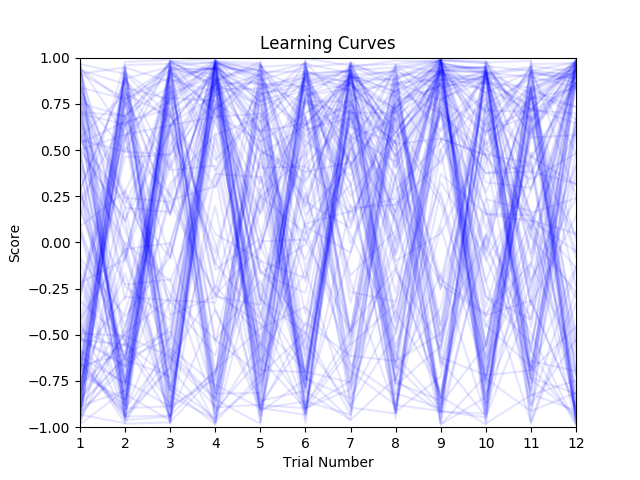

In [5]:
import matplotlib
import matplotlib.pyplot as plt

x = []
for i in range(12):
    x += [i + 1]
series = pd.DataFrame(skouraseries)
series = series.sort_values(by=['ID'])
series = series.to_numpy()#[0][1:]
fig, ax = plt.subplots()
for j in range(len(series)):
    ax.plot(x, series[j][1:], color='b', alpha=0.1)

# set ticks and tick labels
ax.set_xlim((1, 12))
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.set_ylim(-1, 1)

plt.xlabel('Trial Number')
plt.ylabel('Score')
plt.title('Learning Curves')

plt.show()

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 55em; }</style>"))

<IPython.core.display.Javascript object>


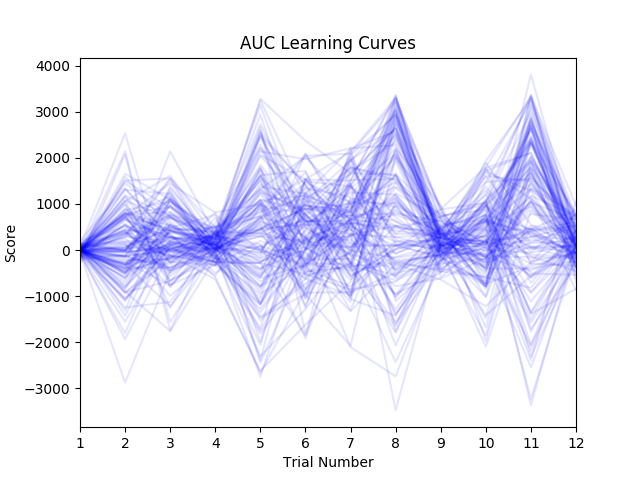

In [6]:
import matplotlib
import matplotlib.pyplot as plt

x = []
for i in range(12):
    x += [i + 1]
series = pd.DataFrame(aucseries)
series = series.sort_values(by=['ID'])
series = series.to_numpy()#[0][1:]
fig, ax = plt.subplots()
for j in range(len(series)):
    ax.plot(x, series[j][1:], color='b', alpha=0.1)

# set ticks and tick labels
ax.set_xlim((1, 12))
ax.set_xticks(x)
ax.set_xticklabels(x)
#ax.set_ylim(-1, 1)

plt.xlabel('Trial Number')
plt.ylabel('Score')
plt.title('AUC Learning Curves')

plt.show()

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 55em; }</style>"))

Skourascore Downregulation-only learning curves

<IPython.core.display.Javascript object>


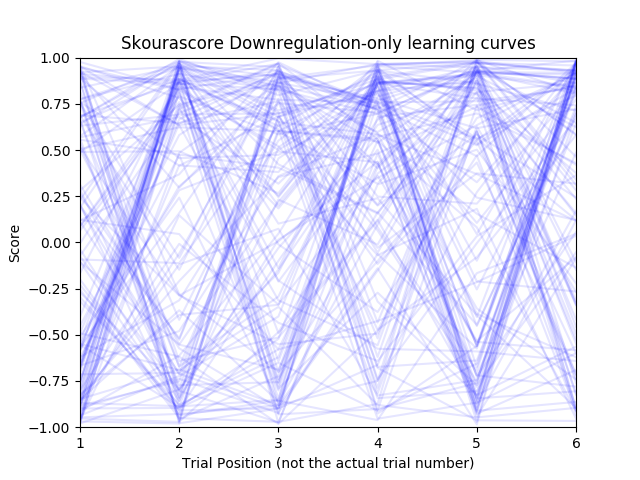

In [7]:
import matplotlib
import matplotlib.pyplot as plt

x = []
for i in range(6):
    x += [i + 1]
    
dseries = pd.DataFrame(skouradownseries)
dseries = dseries.sort_values(by=['ID'])
dseries = dseries.to_numpy()#[0][1:]
fig, ax = plt.subplots()
for j in range(len(dseries)):
    ax.plot(x, dseries[j][1:], color='b', alpha=0.1)

# set ticks and tick labels
ax.set_xlim((1, 6))
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.set_ylim(-1, 1)

plt.xlabel('Trial Position (not the actual trial number)')
plt.ylabel('Score')
plt.title('Skourascore Downregulation-only learning curves')

plt.show()

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 55em; }</style>"))

Now graphing Downregulation-only learning curves with AUCs

<IPython.core.display.Javascript object>


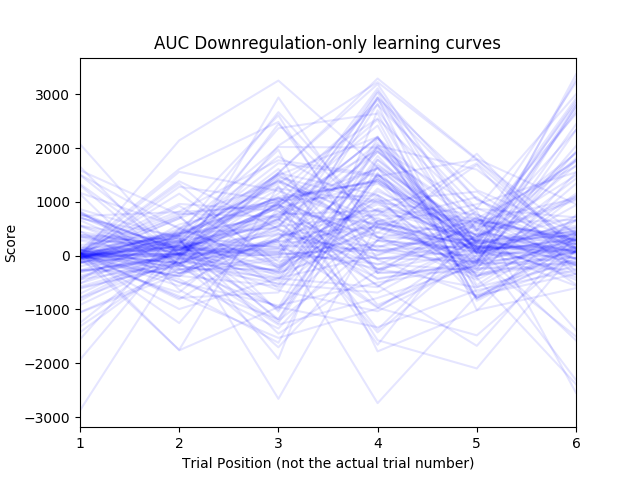

In [8]:
import matplotlib
import matplotlib.pyplot as plt

x = []
for i in range(6):
    x += [i + 1]
    
dseries = pd.DataFrame(aucdownseries)
dseries = dseries.sort_values(by=['ID'])
dseries = dseries.to_numpy()#[0][1:]
fig, ax = plt.subplots()
for j in range(len(dseries)):
    ax.plot(x, dseries[j][1:], color='b', alpha=0.1)

# set ticks and tick labels
ax.set_xlim((1, 6))
ax.set_xticks(x)
ax.set_xticklabels(x)
#ax.set_ylim(-1, 1)

plt.xlabel('Trial Position (not the actual trial number)')
plt.ylabel('Score')
plt.title('AUC Downregulation-only learning curves')

plt.show()

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 55em; }</style>"))

Skourascore Upregulation-only learning curves

<IPython.core.display.Javascript object>


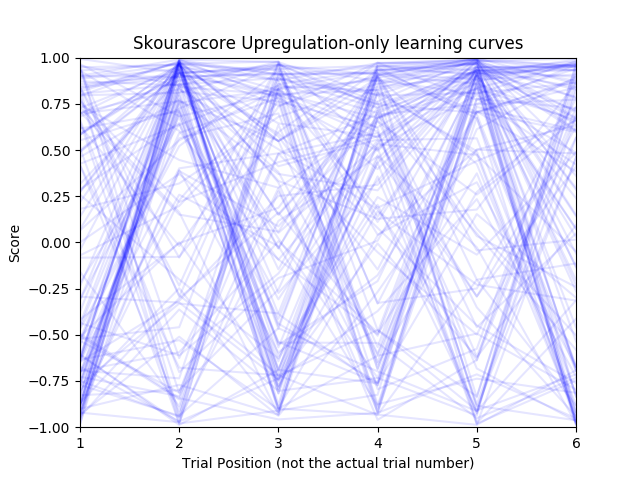

In [9]:
import matplotlib
import matplotlib.pyplot as plt

x = []
for i in range(6):
    x += [i + 1]
    
useries = pd.DataFrame(upseries)
useries = useries.sort_values(by=['ID'])
useries = useries.to_numpy()#[0][1:]
fig, ax = plt.subplots()
for j in range(len(useries)):
    ax.plot(x, useries[j][1:], color='b', alpha=0.1)

# set ticks and tick labels
ax.set_xlim((1, 6))
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.set_ylim(-1, 1)

plt.xlabel('Trial Position (not the actual trial number)')
plt.ylabel('Score')
plt.title('Skourascore Upregulation-only learning curves')

plt.show()

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 55em; }</style>"))

AUC Upregulation-only learning curves

<IPython.core.display.Javascript object>


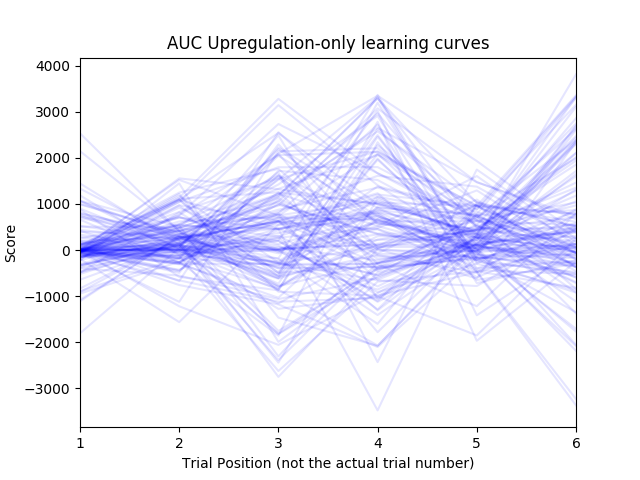

In [10]:
import matplotlib
import matplotlib.pyplot as plt

x = []
for i in range(6):
    x += [i + 1]
    
useries = pd.DataFrame(aucupseries)
useries = useries.sort_values(by=['ID'])
useries = useries.to_numpy()#[0][1:]
fig, ax = plt.subplots()
for j in range(len(useries)):
    ax.plot(x, useries[j][1:], color='b', alpha=0.1)

# set ticks and tick labels
ax.set_xlim((1, 6))
ax.set_xticks(x)
ax.set_xticklabels(x)

plt.xlabel('Trial Position (not the actual trial number)')
plt.ylabel('Score')
plt.title('AUC Upregulation-only learning curves')

plt.show()

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 55em; }</style>"))

Now I'll check histograms for each trial. I think I'll try skourascore downregulation-only to avoid mixing them.

            ID         1         2         3         4         5         6
0    A00028185 -0.666508  0.735094  0.970328  0.558695 -0.719157 -0.780337
1    A00032875 -0.898489 -0.895583 -0.651572 -0.911242 -0.655593  0.839463
2    A00033747  0.959709 -0.280033 -0.699137  0.862805  0.913998  0.908893
3    A00034854 -0.620713 -0.313419  0.550405  0.957702  0.985941  0.812171
4    A00035072  0.085656  0.790296  0.584729  0.695452  0.941998  0.646857
..         ...       ...       ...       ...       ...       ...       ...
133  A00066827  0.281650  0.744215 -0.930396 -0.901703 -0.760790  0.974477
134  A00066926 -0.546585  0.980773  0.846103  0.597506  0.892420 -0.330294
135  A00072203 -0.092233 -0.112006  0.634697 -0.116508  0.432027 -0.712339
136  A00073600 -0.822535 -0.392421 -0.337617  0.869577  0.832783  0.375537
137  A00073677 -0.978632  0.869675  0.966693 -0.319988 -0.826052 -0.563680

[138 rows x 7 columns]


<IPython.core.display.Javascript object>


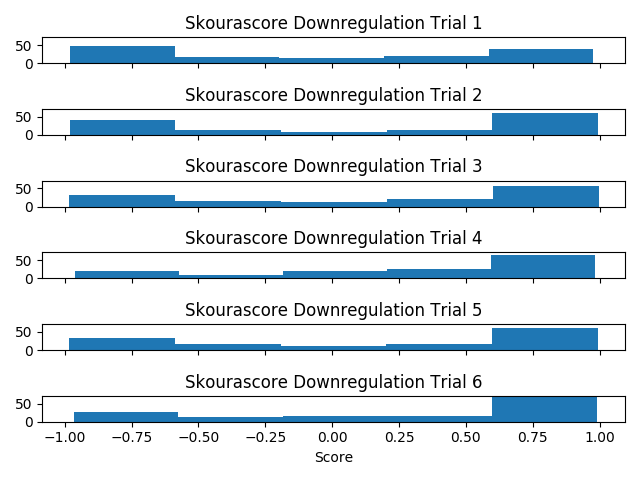

In [11]:
import matplotlib
import matplotlib.pyplot as plt

dseries = pd.DataFrame(downseries)
dseries = dseries.sort_values(by=['ID'])
print(dseries)

n_bins = 5

fig, axs = plt.subplots(6, 1, sharey=True, sharex=True)
for trialPos in range(6):
    axs[trialPos].hist(dseries[str(trialPos + 1)].to_list(), bins=n_bins)
    axs[trialPos].set_title('Skourascore Downregulation Trial ' + str(trialPos + 1))
plt.xlabel('Score')
plt.tight_layout()
plt.show()

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 55em; }</style>"))

Now AUC downregulation-only.

            ID          1          2          3          4          5  \
0    A00028185  -300.3370    23.4705  1538.1785  1131.9185    51.4290   
1    A00032875   -27.3375 -1749.1730  1300.7510  -913.6710  -156.0885   
2    A00033747  1308.1880  -242.0725  -958.2885  2046.5600  1601.2100   
3    A00034854    -0.4015   448.2390  1015.4985  1406.2570   368.7250   
4    A00035072   -10.6340  2143.6545  3256.1180  1640.6210   472.5105   
..         ...        ...        ...        ...        ...        ...   
133  A00066827   347.9090    48.7225  -641.9375 -1033.0030   -99.9465   
134  A00066926  -129.2350   384.9625  1341.4790  2552.1410   774.6520   
135  A00072203  -137.2570   369.5880   145.6145  1628.4750  -585.0405   
136  A00073600    -2.5305   -13.7125  1424.9825   337.8245   295.1870   
137  A00073677 -1554.1375   511.0480  1276.8310 -1570.8630 -2096.3310   

             6  
0      63.3115  
1    2791.3585  
2     224.6070  
3    2925.2630  
4    3219.5200  
..         ...  
133 

<IPython.core.display.Javascript object>


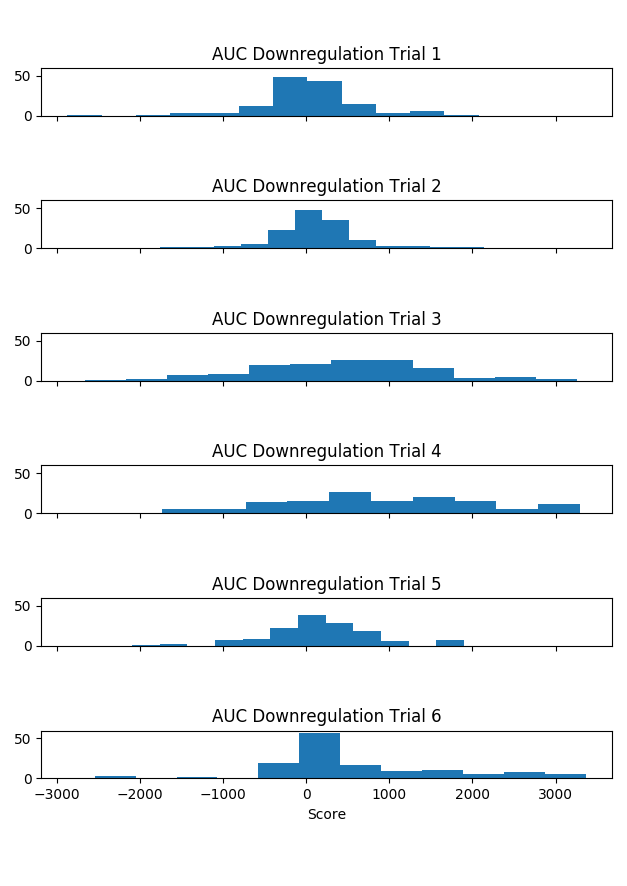

In [19]:
import matplotlib
import matplotlib.pyplot as plt

dseries = pd.DataFrame(aucdownseries)
dseries = dseries.sort_values(by=['ID'])
print(dseries)

n_bins = 12

fig, axs = plt.subplots(6, 1, sharey=True, sharex=True)
for trialPos in range(6):
    axs[trialPos].hist(dseries[str(trialPos + 1)].to_list(), bins=n_bins)
    axs[trialPos].set_title('AUC Downregulation Trial ' + str(trialPos + 1))
plt.xlabel('Score')
plt.tight_layout()
plt.show()

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 55em; }</style>"))